In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Loading and preprocessing images (VGG16, load_img, img_to_array, preprocess_input)
2. Preprocessing text data (Tokenizer, pad_sequences)
3. Building and visualizing deep learning models (Model, plot_model)
4. Defining layers for the captioning model (Dense, LSTM, Embedding, Dropout, add)
5. Handling data operations (numpy, pickle, os)
6. Displaying progress bars (tqdm)

The goal is to extract features from images using a pretrained VGG16 model and build a neural network to generate meaningful captions for images.

In [11]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [12]:
BASE_DIR = '/content/drive/MyDrive/Image Captioning System'
directory = os.path.join(BASE_DIR, 'Flickr8k_50_Images')  # Path to images
CAPTIONS_FILE = os.path.join(BASE_DIR, 'Flickr8k_50_Captions.txt')  # Path to captions file
WORKING_DIR = '/content/drive/MyDrive/Image Captioning System/Working Directory'
os.makedirs(WORKING_DIR, exist_ok=True)  # Ensure the directory exists

In [13]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [14]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm
import os
# Dictionary to store image features
features = {}

# Loop through each image file in the directory
for img_name in tqdm(os.listdir(directory)):
    # Full path to image
    img_path = os.path.join(directory, img_name)

    # Load and preprocess the image
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    # Extract features
    feature = model.predict(image, verbose=0)

    # Get image ID without extension
    image_id = os.path.splitext(img_name)[0]

    # Store features using image ID
    features[image_id] = feature

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
100%|██████████| 50/50 [00:55<00:00,  1.11s/it]


In [15]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [16]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [17]:
#CAPTIONS_FILE = os.path.join(BASE_DIR, 'Flickr8k_50_Captions.txt')
with open(CAPTIONS_FILE, 'r') as f:
    next(f)  # Skip the header line, if there's one
    captions_doc = f.read()

In [18]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

100%|██████████| 250/250 [00:00<00:00, 177875.49it/s]


In [19]:
len(mapping)

50

In [20]:
import re # which provides regular expression support

def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.
            caption = re.sub(r'[^a-zA-Z]', ' ', caption)
            # delete additional spaces
            caption = re.sub(r'\s+', ' ', caption)
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption


In [21]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [22]:
# preprocess the text
clean(mapping)

In [23]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [24]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [25]:
len(all_captions)

250

In [26]:
all_captions[:20]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq',
 'startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
 'startseq little girl is sitting in front of large painted rainbow endseq',
 'startseq small girl in the grass plays with fingerpaints in front of white canvas 

In [27]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [28]:
vocab_size

513

In [29]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

23

In [30]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [31]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [32]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

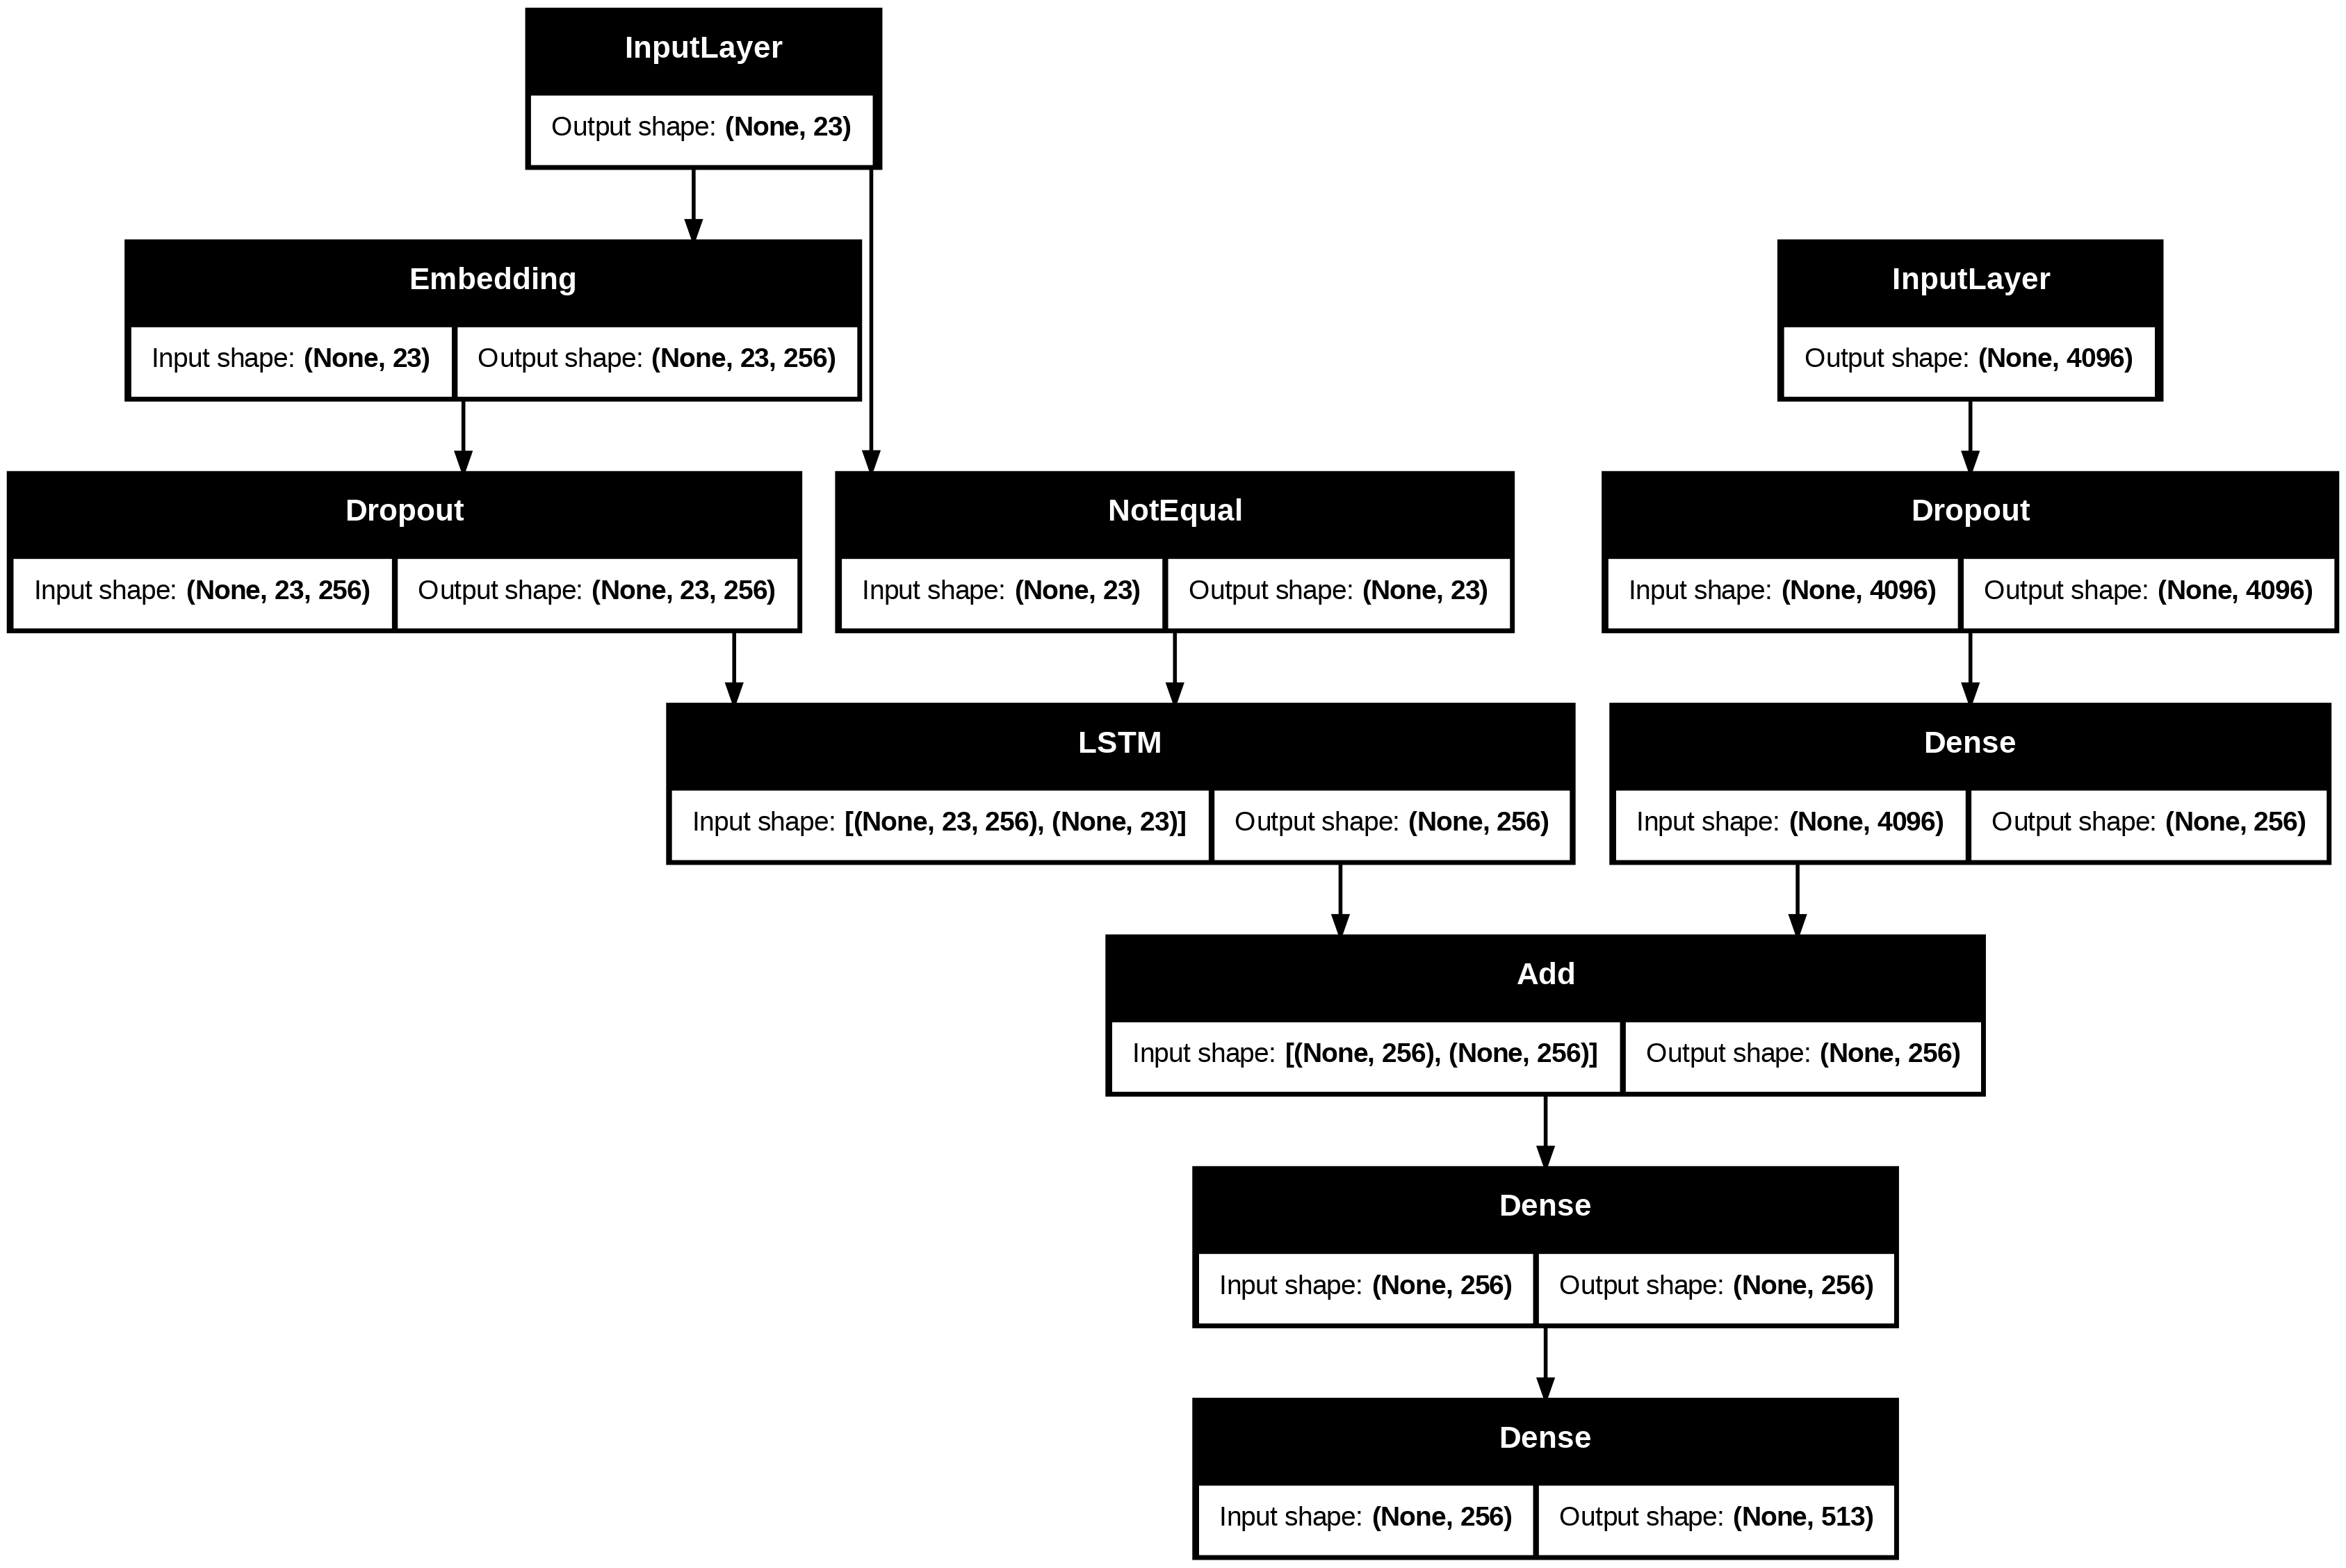

In [33]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [34]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 6.6460
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 5.7727
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 5.4171
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 5.1331
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 4.9328
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 4.7695
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 4.5801
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 4.4876
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 4.3425
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 4.2394
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 4.1629
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 4.0703
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 3.9800
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 3.9197
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 3.8323
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 3.7695
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 3.6910
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 3.6210
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 3.5508
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/

In [35]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

In [36]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


In [37]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'

    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with highest probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += ' ' + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [38]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
 20%|██        | 1/5 [00:00<00:03,  1.03it/s]

BLEU-1: 0.322696
BLEU-2: 0.174276


 40%|████      | 2/5 [00:02<00:03,  1.03s/it]

BLEU-1: 0.325433
BLEU-2: 0.130946


 60%|██████    | 3/5 [00:02<00:01,  1.16it/s]

BLEU-1: 0.338307
BLEU-2: 0.114369


 80%|████████  | 4/5 [00:03<00:00,  1.11it/s]

BLEU-1: 0.313768
BLEU-2: 0.096427


100%|██████████| 5/5 [00:04<00:00,  1.09it/s]

BLEU-1: 0.303641
BLEU-2: 0.086325


In [39]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # Get the image ID (without extension)
    image_id = image_name.split('.')[0]

    # Construct full image path using the updated directory path
    img_path = os.path.join(directory, image_name)

    # Load the image
    image = Image.open(img_path)

    # Display actual captions
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)

    # Predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)

    # Show the image
    plt.imshow(image)
    plt.axis('off')  # Optional: hides the axis
    plt.show()

---------------------Actual---------------------
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq
--------------------Predicted--------------------
startseq going going going going going going going endseq


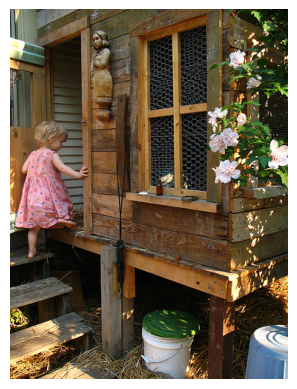

In [40]:
generate_caption("1000268201_693b08cb0e.jpg")

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq dog dog other other other other other endseq


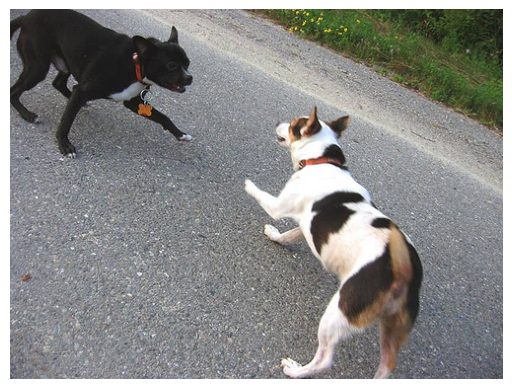

In [41]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq little girl looking at brochure on train rides endseq
startseq young blond girl with magizine in her hands endseq
startseq young girl on train reads book about train rides endseq
startseq young girl sits on seat and looks at train pamphlet endseq
startseq child sitting down looking at train ride brochure endseq
--------------------Predicted--------------------
startseq with with with with with with with with with with endseq


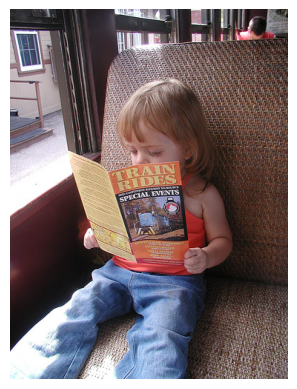

In [43]:
generate_caption("1056359656_662cee0814.jpg")